### A full training loop

We will now look at a 2-class classification problem with a generated toy-dataset.
The data will be stored inside a PyTorch `Dataset` subclass, which will provide you with some utilities like automatic shuffling and batching for the training loop, if paired with `DataLoader`.

The 2 classes are two normal distributions with different means.

In [1]:
%pip install matplotlib # install using pip
#%conda install -y matplotlib # or install using conda

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


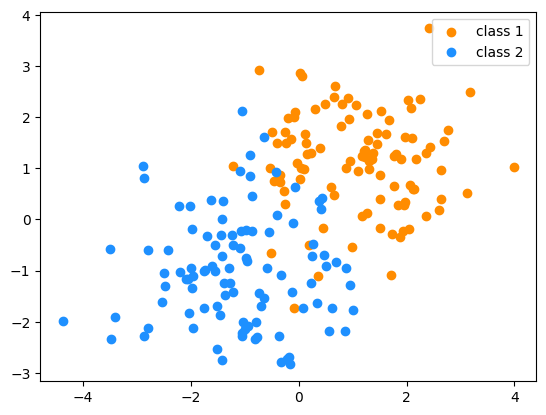

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

class TwoClassDataset(Dataset):
    def __init__(self):
        # create synthetic dataset
        self.features_a = torch.normal(mean=1., std=1.0, size=(100,2))
        self.labels_a = torch.zeros(100, dtype=torch.long)
        self.features_b = torch.normal(mean=-1.0, std=1.0, size=(100,2))
        self.labels_b = torch.ones(100, dtype=torch.long)

        self.data = torch.cat((self.features_a, self.features_b), dim=0) # X: 200 x 2 matrix : [x1,x2]
        self.labels = torch.cat((self.labels_a, self.labels_b), dim=0) # Y: binary vector of length 200: 0: class A, 1: class B
    
    def __len__(self):
        return self.data.size(dim=0)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
train_data = TwoClassDataset()

# plot both classes
fig, ax = plt.subplots()
ax.scatter(train_data.features_a[:,0], train_data.features_a[:,1], label="class 1", c="darkorange")
ax.scatter(train_data.features_b[:,0], train_data.features_b[:,1], label="class 2", c="dodgerblue")
ax.legend()
plt.show()

In [3]:
print("first sample input, label:", train_data[0])

first sample input, label: (tensor([0.0284, 2.8652]), tensor(0))


The data loader can shuffle your dataset for each epoch (which you should definitely do to keep mini-batches representative) and also automatically groups your single samples together into matrices for a mini-batch (the first dimension will always be the batch dimension, e.g. if your data point has size $3$, then a batch of size 25 would have size $25 \times 3$.

Let's have a look:

In [4]:
loader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
# get one single batch, in different order each time an iterator is created
batch_samples, batch_labels = next(iter(loader))
print(batch_samples) # samples grouped together to a 5 x 2 matrix (x1, x2)
print(batch_labels)  # labels grouped together to a 5-dimensional vector 

tensor([[ 0.7790,  1.8218],
        [ 1.4575,  1.6835],
        [-2.0520, -1.1568],
        [ 0.1974, -0.4935],
        [ 0.4942,  2.2567]])
tensor([0, 0, 1, 0, 0])


We're creating a new clasifier for our problem, the input size is 2 and the output size is 2 because we want to do multi-class classification (for 2 classes, a sigmoid and a single output would also work).
The activation function here is a ReLU (rectified linear unit) to show some different options. It is piecewise linear: $relu(x) = max(0, x)$

In [5]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # layer1: input 2, output 6
        self.layer1 = torch.nn.Linear(2,6)
        # layer2: input 6, output 6
        self.layer2 = torch.nn.Linear(6,6)
        # layer3: input 6, output 2
        self.out = torch.nn.Linear(6,2)
        
    def forward(self, x):
        # forward pass with ReLU after the first and the second layer
        y = torch.relu(self.layer1(x))
        y = torch.relu(self.layer2(y))
        y = self.out(y)
        return y

In [6]:
%pip install tqdm
#%conda install -y tqdm # or install using conda

Note: you may need to restart the kernel to use updated packages.


For the training loop, we need instances of
* the training data (in real applications, also development / test data)
* a loss criterion (e.g. MSE for regression tasks, Cross Entropy for classification)
* an optimizer

We will iterate many times over the full dataset (each iteration is called an *epoch*).
Each epoch is broken up further into mini-batches that can be adapted to fit e.g. your computer's memory constraints.

For each mini-batch, we need to:
* reset the gradients (otherwise, they will accumulate)
* forward the input data to create predictions
* calculate the loss between the predictions and the gold labels
* calculate the gradient of the loss w.r.t. the network weights (backward pass)
* update the network weights using the gradients and the optimizer

In [7]:
from tqdm import tqdm

# instantiate model, loss criterion and optimizer
classy = Classifier()
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=classy.parameters(), lr=0.01)

# store epoch metrics
epoch_accs = []
epoch_losses = []
dataloader = DataLoader(dataset=train_data, batch_size=25, shuffle=True)

# epoch loop
for epoch in tqdm(range(50)):
    epoch_acc = []
    epoch_loss = []
    
    # mini-batch loop for one epoch
    for batch in dataloader:
        # reset gradients to 0
        optim.zero_grad()
        
        # forward pass
        batch_samples = batch[0] # 25 x 2 -> [x1, x2]
        gold_labels = batch[1]   # 25 -> 0: class A, 1: class B
        predictions = classy(batch_samples)
       
        # loss and backward pass
        loss = loss_func(predictions, gold_labels)
        loss.backward()
        
        # update network weights
        optim.step()
        
        # check accuracy (get predicted class for each sample, compare to gold label)
        category_probs = torch.softmax(predictions, dim=1) # sums up to 1 for each sample
        category_labels = torch.argmax(category_probs, dim=1) # extract most likely label
        batch_acc = (category_labels == gold_labels).float().sum(dim=0)/25.0 # avg accuracy for batch
        epoch_acc.append(batch_acc.item())
        epoch_loss.append(loss.item())

    # average all metrics across one epoch
    epoch_losses.append(sum(epoch_loss)/len(epoch_loss))
    epoch_accs.append(sum(epoch_acc)/len(epoch_acc))
  


100%|██████████| 50/50 [00:02<00:00, 21.75it/s]


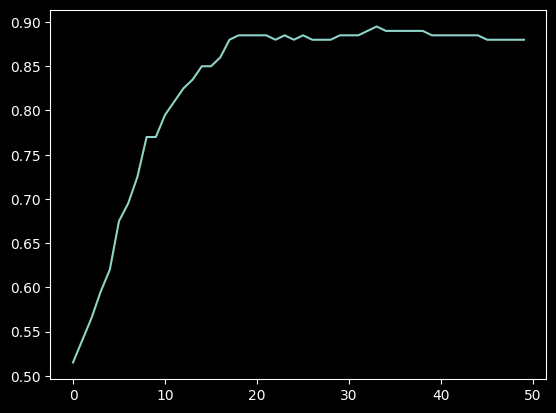

In [8]:
plt.plot(epoch_accs)

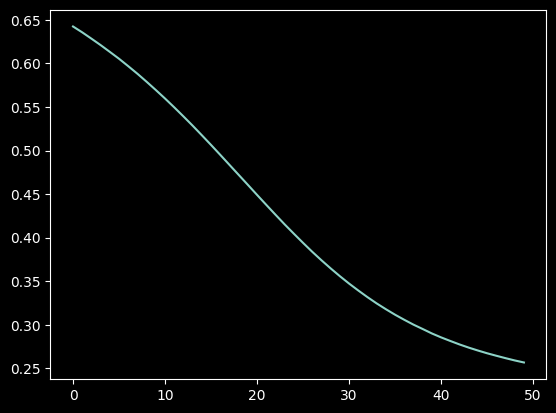

In [9]:
plt.plot(epoch_losses)

We'll visualize the predictions for an unseen test dataset drawn from the same distribution as the training data. Red points mark misclassified samples.

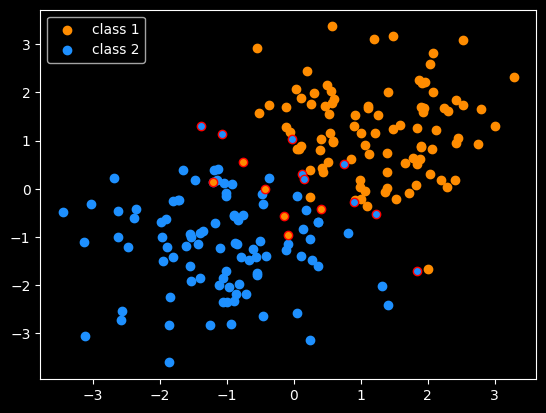

In [10]:
from matplotlib import pyplot as plt

test_data = TwoClassDataset()

predicted_class_a = []
predicted_class_b = []
missclassified_class_a = []
missclassified_class_b = []
for i in range(len(test_data)):
    x, label = test_data[i]
    pred = classy(x)
    probs = torch.softmax(pred, dim=0) # note that the softmax is mathematically not needed since it is a monotonic function
    class_pred = torch.argmax(probs, dim=0)
  
    if label != class_pred:
        if label == 0:
            missclassified_class_a.append(x.unsqueeze(dim=0))
        else:
            missclassified_class_b.append(x.unsqueeze(dim=0))
    else:
        if class_pred == 0:
            predicted_class_a.append(x.unsqueeze(dim=0))
        else:
            predicted_class_b.append(x.unsqueeze(dim=0))
predicted_class_a = torch.cat(predicted_class_a, dim=0) # concatenates tensor along specified, existing dimension, does not create new dimension
predicted_class_b = torch.cat(predicted_class_b, dim=0) # `stack` is an alternative which creates a new dimension (i.e. we wouldn't have `unsqueeze`d the vectors)
missclassified_class_a = torch.cat(missclassified_class_a, dim=0)
missclassified_class_b = torch.cat(missclassified_class_b, dim=0)

fig, ax = plt.subplots()
ax.scatter(predicted_class_a[:,0], predicted_class_a[:,1], label="class 1", c="darkorange")
ax.scatter(predicted_class_b[:,0], predicted_class_b[:,1], label="class 2", c="dodgerblue")
ax.scatter(missclassified_class_a[:,0], missclassified_class_a[:,1], c="darkorange", edgecolors="r")
ax.scatter(missclassified_class_b[:,0], missclassified_class_b[:,1], c="dodgerblue", edgecolors="r")
ax.legend()
plt.show()